In [1]:
# Library

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from random import shuffle

In [2]:
# model_parameters

model_choice = 'BiRNN'

timesteps = 60
sampling_frequency = 40
hidden_layer_units = 10

In [3]:
# create checkpoint path for the model
if model_choice == 'ANN':
    FILEWRITER_PATH = './result/PPG_DAE_ANN_' + str(timesteps) + 'timesteps_' + str(hidden_layer_units) + 'nodes_tensorboard'
    if not os.path.isdir(FILEWRITER_PATH):
        os.makedirs(FILEWRITER_PATH)
    CHECKPOINT_PATH = './result/PPG_DAE_ANN_' + str(timesteps) + 'timesteps_' + str(hidden_layer_units) + 'nodes_tensorboard/checkpoints'
    if not os.path.isdir(CHECKPOINT_PATH):
        os.makedirs(CHECKPOINT_PATH)
elif model_choice == 'RNN':
    FILEWRITER_PATH = './result/PPG_DAE_RNN_' + str(timesteps) + 'timesteps_' + str(hidden_layer_units) + 'nodes_tensorboard'
    if not os.path.isdir(FILEWRITER_PATH):
        os.makedirs(FILEWRITER_PATH)
    CHECKPOINT_PATH = './result/PPG_DAE_RNN_' + str(timesteps) + 'timesteps_' + str(hidden_layer_units) + 'nodes_tensorboard/checkpoints'
    if not os.path.isdir(CHECKPOINT_PATH):
        os.makedirs(CHECKPOINT_PATH)
elif model_choice == 'BiRNN':
    FILEWRITER_PATH = './result/PPG_DAE_BiRNN_' + str(timesteps) + 'timesteps_' + str(hidden_layer_units) + 'nodes_tensorboard'
    if not os.path.isdir(FILEWRITER_PATH):
        os.makedirs(FILEWRITER_PATH)
    CHECKPOINT_PATH = './result/PPG_DAE_BiRNN_' + str(timesteps) + 'timesteps_' + str(hidden_layer_units) + 'nodes_tensorboard/checkpoints'
    if not os.path.isdir(CHECKPOINT_PATH):
        os.makedirs(CHECKPOINT_PATH)

./data/PPG_40Hz_10sec_25000set.txt
The shape of the original dataset is 25000 by 400
The shape of the 60 timestep dataset is 150000 by 60


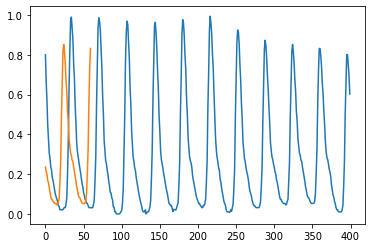

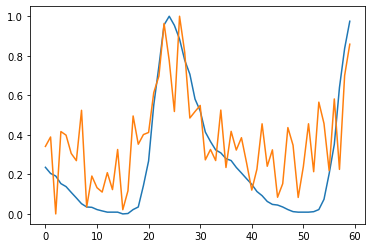

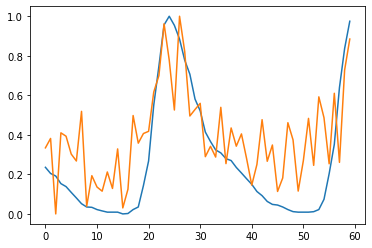

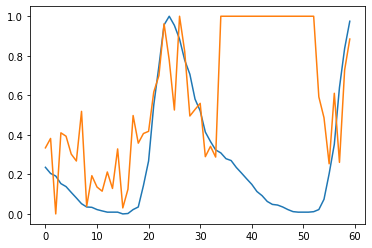

(120000, 60, 1)
(120000, 60)


In [4]:
# -------------------------------------------- load data & pre-processing -------------------------------------------- #

# set this to the path of your data file
PPG_data_path = './data/PPG_40Hz_10sec_25000set.txt'
print(PPG_data_path)

def signal_extraction(data_path):

    # load the dataset
    # the [0] index is there because there is one file in this dataset, if there are more than file for the dataset, do a for-loop to load each data file
    PPG_data = np.loadtxt(data_path)
    print('The shape of the original dataset is %i by %i' % np.shape(PPG_data))  # (10000, 400) -> 10000 rows of 40Hz 10sec PPG data
    print('The shape of the %i timestep dataset is %i by %i' % (timesteps, int(np.ceil((400-timesteps)/timesteps)*len(PPG_data)), timesteps))

    # shuffle the data
    shuffle(PPG_data)

    # create empty lists to hold training and validation datasets
    train_input_data_list = []
    train_output_data_list = []
    val_input_data_list = []
    val_output_data_list = []

    # loop through the original dataset and perform data extraction/noise addition on each row
    for datanum in range(len(PPG_data)):
        # separate the PPG segment in each row into timestep size
        for index in range(0, 400-timesteps, timesteps):

            # ---------- original data, normalized ----------
            a = PPG_data[datanum, index:index + timesteps].copy()
            a = a - np.min(a)
            a = a / np.max(a)

            # ---------- Gaussian noise data ----------
            noise1 = np.random.randn(len(a))/3
            b = a.copy() + noise1
            b = b - np.min(b)
            b = b / np.max(b)

            # ---------- Gaussian noise + low freq noise data ----------
            c = b.copy()
            slope = np.random.randn()
            for i in range(len(c)):
                c[i] = c[i] + slope/len(c)*i
            c = c - np.min(c)
            c = c / np.max(c)

            # ---------- Gaussian noise + low freq noise + saturation data ----------
            d = c.copy()
            location1 = np.random.randint(timesteps)
            location2 = location1 + np.random.randint(timesteps-location1)
            if np.random.rand() > 0:
              d[location1:location2] = np.ones(location2-location1, float)
            else: 
              d[location1:location2] = np.zeros(location2-location1, float)
            

            # put 80% of the data into the training dataset list, and 20% into the validation dataset list
            if datanum < 0.8 * len(PPG_data):
              if np.sum(np.isfinite(a))== len(a) and np.sum(np.isfinite(d))== len(d):
                train_input_data_list.append(d)  # CHANGE THIS TO THE NOISE-AUGMENTED DATA
                train_output_data_list.append(a)
            else:
              if np.sum(np.isfinite(a))== len(a) and np.sum(np.isfinite(d))== len(d):
                val_input_data_list.append(d)  # CHANGE THIS TO THE NOISE-AUGMENTED DATA
                val_output_data_list.append(a)

    # plot the last data
    plt.figure()
    plt.plot(PPG_data[datanum])
    plt.plot(PPG_data[datanum,index:index + timesteps])
    plt.show()
    plt.figure()
    plt.plot(a)
    plt.plot(b)
    plt.show()
    plt.figure()
    plt.plot(a)
    plt.plot(c)
    plt.show()
    plt.figure()
    plt.plot(a)
    plt.plot(d)
    plt.show()

    # convert the dataset lists into arrays
    train_input_data_list = np.asarray(train_input_data_list)
    train_output_data_list = np.asarray(train_output_data_list)
    val_input_data_list = np.asarray(val_input_data_list)
    val_output_data_list = np.asarray(val_output_data_list)

    return train_input_data_list, train_output_data_list, val_input_data_list, val_output_data_list


[train_input_data_list, train_answer_data_list, val_input_data_list, val_answer_data_list] = signal_extraction(PPG_data_path)

# if the deep learning model used here is recurrent, need to reshape the input data to match the keras LSTM input_shape
if model_choice == 'RNN' or model_choice == 'BiRNN':
    train_input_data_list = np.reshape(train_input_data_list, [len(train_input_data_list), timesteps, 1])
    val_input_data_list = np.reshape(val_input_data_list, [len(val_input_data_list), timesteps, 1])

print(np.shape(train_input_data_list))
print(np.shape(train_answer_data_list))



In [5]:
# ------------------------------------------ deep learning model definition ------------------------------------------ #

def ANN():
    
    model_inputs = tf.keras.Input(shape=(timesteps, ))
    encoding_layer = tf.keras.layers.Dense(units=hidden_layer_units, activation='sigmoid', input_shape=(timesteps, ))(model_inputs)
    out_layer = tf.keras.layers.Dense(units=timesteps, activation='sigmoid')(encoding_layer)
    
    model = tf.keras.Model(inputs=model_inputs, ouputs=out_layer)
    
    return model


def RNN():
    
    model_inputs = tf.keras.Input(shape=(timesteps, 1))
    encoding_layer = tf.keras.layers.LSTM(units=hidden_layer_units, activation='sigmoid', input_shape=(timesteps, 1))(model_inputs)
    out_layer = tf.keras.layers.Dense(units=timesteps, activation='sigmoid')(encoding_layer)
    
    model = tf.keras.Model(inputs=model_inputs, outputs=out_layer)
    
    return model


def BiRNN():
    
    model_inputs = tf.keras.Input(shape=(timesteps, 1))
    encoding_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=hidden_layer_units, activation='sigmoid', input_shape=(timesteps, 1)))(model_inputs)
    out_layer = tf.keras.layers.Dense(units=timesteps, activation='sigmoid')(encoding_layer)

    model = tf.keras.Model(inputs=model_inputs, outputs=out_layer)

    return model

def BiRNN_MM():

    model_inputs = tf.keras.Input(shape=(timesteps, 1))
    encoding_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=1, activation='sigmoid', return_sequences=True, input_shape=(timesteps, 1)))(model_inputs)
    out_layer = tf.keras.layers.Dense(units=timesteps, activation='sigmoid')(encoding_layer)

    model = tf.keras.Model(inputs=model_inputs, outputs=out_layer)

    return model

print('Setting model complete')
    

Setting model complete


In [6]:

if model_choice == 'ANN':
    DAE = ANN()
elif model_choice == 'RNN':
    DAE = RNN()
elif model_choice == 'BiRNN':
    DAE = BiRNN()

# compile the model with optimizer and loss function
# opt = tf.keras.optimizers.Adam(learning_rate=1)
DAE.compile(optimizer='adam', loss='mse')
cp_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, verbose=1, save_best_only=True, save_weights_only=True, period=1)

# train the model
a = DAE.fit(train_input_data_list, train_answer_data_list, epochs=1000, batch_size=40000, shuffle=True, validation_data=(val_input_data_list, val_answer_data_list), verbose=2, callbacks=[cp_callback])

Epoch 1/1000

Epoch 1: val_loss improved from inf to 0.12748, saving model to ./result/PPG_DAE_BiRNN_60timesteps_10nodes_tensorboard\checkpoints
3/3 - 7s - loss: 0.1286 - val_loss: 0.1275 - 7s/epoch - 2s/step
Epoch 2/1000

Epoch 2: val_loss improved from 0.12748 to 0.12556, saving model to ./result/PPG_DAE_BiRNN_60timesteps_10nodes_tensorboard\checkpoints
3/3 - 6s - loss: 0.1267 - val_loss: 0.1256 - 6s/epoch - 2s/step
Epoch 3/1000

Epoch 3: val_loss improved from 0.12556 to 0.12373, saving model to ./result/PPG_DAE_BiRNN_60timesteps_10nodes_tensorboard\checkpoints
3/3 - 6s - loss: 0.1248 - val_loss: 0.1237 - 6s/epoch - 2s/step
Epoch 4/1000

Epoch 4: val_loss improved from 0.12373 to 0.12198, saving model to ./result/PPG_DAE_BiRNN_60timesteps_10nodes_tensorboard\checkpoints
3/3 - 5s - loss: 0.1230 - val_loss: 0.1220 - 5s/epoch - 2s/step
Epoch 5/1000

Epoch 5: val_loss improved from 0.12198 to 0.12031, saving model to ./result/PPG_DAE_BiRNN_60timesteps_10nodes_tensorboard\checkpoints
3/3

KeyboardInterrupt: 